In [334]:
#importing all necessary libraries
import torch as pyt
import torchvision as tv
import math
from torch import nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from torch import optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [335]:
#defining method for plot display
def matplotlib_imshow(img, one_channel = False):
    if one_channel:
        img = img.mean(dim=0)
    img = img/2+0.5 #denormalize
    npimg = img.numpy()
    if one_channel:
        plt.imgshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg,(1,2,0)))

In [336]:
#confirming pytorch detects macbook m2 CPU and GPU chips
print(pyt.backends.mps.is_available())
print(pyt.backends.mps.is_built())


True
True


In [337]:
#Import data and separating features and dependent output variables
#trainset = features(X), trainlabels = dependent variables = (y)
trainset = pd.read_csv('../Data/train.csv')
trainlabels = trainset.pop("WY.Tot.Consump.MMBtu")

In [338]:
#display training data to ensure looks correct
display(trainset)

,Month,Date,Year,NG.Consump.MMBtu,Coal.Consump.MMBtu,Tot.Consump.MMBtu,X...Per.kwh.Mo.Albany,Albany,Big.Horn,Campbell,...,ELEC.GEN.PEL-WY-99.M,ELEC.GEN.PC-WY-99.M,ELEC.GEN.NG-WY-99.M,ELEC.GEN.OOG-WY-99.M,ELEC.GEN.NUC-WY-99.M,ELEC.GEN.HYC-WY-99.M,ELEC.GEN.AOR-WY-99.M,ELEC.GEN.HPS-WY-99.M,ELEC.GEN.OTH-WY-99.M,ELEC.GEN.TSN-WY-99.M
0,1,1,2001,1,42,43,7.92,17.1,16.6,27.7,...,3,0,58,1,0,44,26,0,7,0
1,2,1,2001,1,40,41,7.92,20.2,14.6,19.1,...,2,0,50,1,0,38,23,0,6,0
2,3,1,2001,1,43,44,7.92,29.4,36.2,33.8,...,2,0,58,1,0,47,22,0,7,0
3,4,1,2001,1,36,37,7.92,38.8,47.1,44.1,...,2,0,41,1,0,68,13,0,7,0
4,5,1,2001,0,36,36,7.92,48.9,59.4,54.1,...,4,0,35,1,0,103,16,0,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,3,1,2017,1,34,35,14.51,38.0,43.4,41.9,...,2,0,56,33,0,101,413,0,6,0
195,4,1,2017,1,26,27,14.51,38.4,47.3,43.9,...,5,0,65,33,0,98,409,0,5,0
196,5,1,2017,1,31,32,14.51,46.4,56.6,53.1,...,8,0,67,26,0,99,391,0,0,0
197,6,1,2017,1,36,37,14.51,59.7,68.3,64.5,...,4,0,49,22,0,106,295,0,0,0


In [339]:
#show testlabels to make sure pulling right column and right dimensions
display(trainlabels)

0      35.86500
1      32.80100
2      33.76600
3      35.60893
4      33.21135
         ...   
194    37.38332
195    35.55559
196    36.12317
197    27.95936
198    30.56892
Name: WY.Tot.Consump.MMBtu, Length: 199, dtype: float64

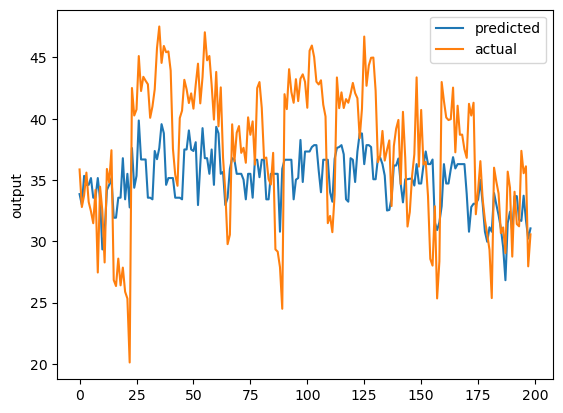

In [340]:
# define method to send pandas data to pytorch tensor
def to_tensor(df): return pyt.tensor(df.values.astype(np.float32))

traindata_ts, traintarget_ts = to_tensor(trainset), to_tensor(trainlabels)

#Define the Neural Net Class
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #currently the net runs a linear regression - should it?
        self.l1=nn.Linear(54,250)
        self.l2=nn.Linear(250,1)
        
        self.layer_in = None
        self.act_1 = None
        self.act_2 = None
        self.layer_out = None
        
    def forward(self, x):
        self.layer_in = self.l1(x)
        self.act_1 = pyt.tanh(self.layer_in)
        self.layer_out = self.l2(self.act_1)
        self.act_2 = pyt.sigmoid(self.layer_out)
        #print("IN:", self.layer_in, "ONE:", self.act_1, "OUT:", self.layer_out, "TWO:", self.act_2)
        return self.act_2

#initialize the model
model = Net()

#initialize the error
error = 0
step_loss = []
    
#loss is calculated using mean squared error loss
mn_loss = nn.L1Loss()
mnse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

optimizer = pyt.optim.Adam(model.parameters(), lr=0.01/traindata_ts.shape[0],weight_decay=0.005)

num_epochs = 5000
#run gradient descent on data
for epoch in range(num_epochs):
    #begin with zero gradient, forward pass compute predicted output passing training_data to model
    #producing tensor with output data.
    optimizer.zero_grad()
    output = model(traindata_ts)
    #print(output)
     
    #calculate loss based on loss function of predicted output vs target data
    trainloss = ce_loss(output.squeeze(), traintarget_ts.squeeze())
    
    #backward pass to compute gradient of loss with respect to all learnable params in model & take step
    trainloss.backward()

    #update weights
    optimizer.step()
    
    step_loss.append(trainloss)
    #if epoch % (num_epochs/5) == 0: 
     #   print(loss)




#reverse scaling of training data and model prediction
scaler = MinMaxScaler()
scaler0=scaler.fit(np.expand_dims(traintarget_ts,axis=1))
traintrue=scaler0.inverse_transform(np.expand_dims(traintarget_ts.squeeze().detach().numpy().flatten(),axis=0)).flatten()
trainpred=scaler0.inverse_transform(np.expand_dims(output.squeeze().detach().numpy(),axis=0)).flatten()
#print("train prediction: ", trainpred)
#print("train actual: ", traintarget_ts.squeeze())

plt.figure()
plt.plot(trainpred, label="predicted")
plt.plot(traintarget_ts.squeeze(), label="actual")
plt.ylabel("output")
plt.legend()
plt.show()


In [341]:
#Import data and separating features and dependent output variables
#trainset = features(X), testlabels = dependent variables = (y)
testset = pd.read_csv('../Data/test.csv')
testlabels = testset.pop("WY.Tot.Consump.MMBtu")

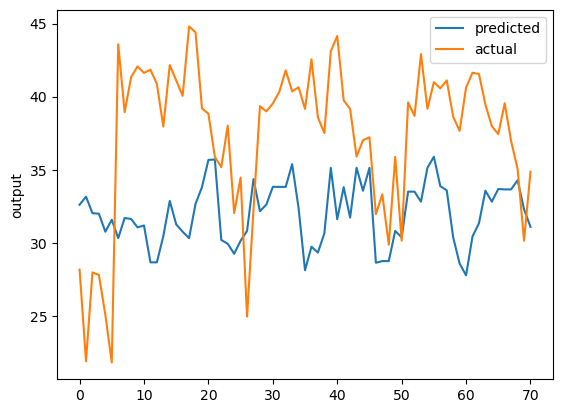

In [342]:
#load test data and run model against

testdata_ts, testtarget_ts = to_tensor(testset), to_tensor(testlabels)
testoutput = model(testdata_ts)

#reverse scaling of test data and model prediction
scaler = MinMaxScaler()
scaler0=scaler.fit(np.expand_dims(testtarget_ts,axis=1))
testtrue=scaler0.inverse_transform(np.expand_dims(testtarget_ts.squeeze().detach().numpy().flatten(),axis=0)).flatten()
testpred=scaler0.inverse_transform(np.expand_dims(testoutput.squeeze().detach().numpy(),axis=0)).flatten()
#print("test prediction: ", trainpred)
#print("test actual: ", traintarget_ts.squeeze())

#plot the performance of the model against test data
plt.figure()
plt.plot(testpred, label="predicted")
plt.plot(testtarget_ts.squeeze(), label="actual")
plt.ylabel("output")
plt.legend()
plt.show()

In [345]:
def saveModel():
    path = "./NetModel.pth"
    torch.save(model.state_dict(), path)